In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

# from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


from Model import CNN

import time
from datetime import timedelta

In [19]:
data_dir = './/Flowers'
BATCH_SIZE = 16
MAX_EPOCHS = 20

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f' Training on {device}')



 Training on cuda


In [20]:

dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))


In [21]:

num_channels = dataset[0][0].shape[0]
num_classes = len(dataset.classes)

In [22]:
temp_data, test_data = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
len(temp_data),len(test_data)

(768, 192)

In [23]:

train_data, val_data = random_split(temp_data, [int(len(temp_data)*0.75), int(len(temp_data)*0.25)])
len(train_data),len(val_data)


(576, 192)

In [24]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)


In [25]:

trainSteps = len(train_loader)         #  len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader)              #   len(val_loader.dataset) // BATCH_SIZE

trainSteps, valSteps


(36, 12)

In [26]:

model = CNN(num_channels,num_classes)
for n,v in model.named_parameters():
    print(f'{n} : {v.shape}')



conv1.weight : torch.Size([64, 3, 3, 3])
conv1.bias : torch.Size([64])
conv2.weight : torch.Size([32, 64, 5, 5])
conv2.bias : torch.Size([32])
fc1.weight : torch.Size([128, 39200])
fc1.bias : torch.Size([128])
fc2.weight : torch.Size([12, 128])
fc2.bias : torch.Size([12])


In [27]:

model.to(device)

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [28]:
strtm = time.time()
# iterator = tqdm(range(1,MAX_EPOCHS+1), total=MAX_EPOCHS+1)
# for epoch in iterator:
for epoch in range(1, MAX_EPOCHS+1):    
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0
    
    for (inputs,labels) in train_loader:
        (inputs, labels) = (inputs.to(device),labels.to(device))
        # labels = torch.tensor(labels)
        preds = model(inputs)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss
        trainCorrect += (preds.argmax(1) == labels).type(torch.float).sum().item()       
    
    with torch.no_grad():
        model.eval()
        for (inputs,labels) in val_loader:
            (inputs, labels) = (inputs.to(device),labels.to(device))
        
            preds = model(inputs)
            loss = criterion(preds, labels)
            totalValLoss += loss
            valCorrect += (preds.argmax(1) == labels).type(
				torch.float).sum().item()
    
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    trainCorrect = trainCorrect / len(train_loader.dataset)
    valCorrect = valCorrect / len(val_loader.dataset)
	
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    # iterator.write(f"""
    # EPOCH: {epoch}/{MAX_EPOCHS}Train loss: {avgTrainLoss:.4f}, Train accuracy: {trainCorrect:.4f} Val loss: {avgValLoss:.4f}, Val accuracy: {valCorrect:.4f}
    # """)
	 
    print(f"EPOCH: {epoch}/{MAX_EPOCHS}")
    print(f"Train loss: {avgTrainLoss:.4f}, Train accuracy: {trainCorrect:.4f}")
    print(f"Val loss: {avgValLoss:.4f}, Val accuracy: {valCorrect:.4f}")

print('Finished training')

entm = time.time()


EPOCH: 1/20
Train loss: 2.4844, Train accuracy: 0.1059
Val loss: 2.4762, Val accuracy: 0.0990
EPOCH: 2/20
Train loss: 2.4502, Train accuracy: 0.1493
Val loss: 2.4418, Val accuracy: 0.1875
EPOCH: 3/20
Train loss: 2.3608, Train accuracy: 0.2240
Val loss: 2.3283, Val accuracy: 0.1927
EPOCH: 4/20
Train loss: 2.0640, Train accuracy: 0.3021
Val loss: 1.9573, Val accuracy: 0.2604
EPOCH: 5/20
Train loss: 1.7061, Train accuracy: 0.3733
Val loss: 1.7566, Val accuracy: 0.3490
EPOCH: 6/20
Train loss: 1.5679, Train accuracy: 0.4514
Val loss: 1.6967, Val accuracy: 0.3646
EPOCH: 7/20
Train loss: 1.3562, Train accuracy: 0.4931
Val loss: 1.5302, Val accuracy: 0.4115
EPOCH: 8/20
Train loss: 1.2113, Train accuracy: 0.5642
Val loss: 1.5859, Val accuracy: 0.4479
EPOCH: 9/20
Train loss: 1.1120, Train accuracy: 0.6302
Val loss: 1.4036, Val accuracy: 0.4948
EPOCH: 10/20
Train loss: 1.0374, Train accuracy: 0.6146
Val loss: 1.4020, Val accuracy: 0.4271
EPOCH: 11/20
Train loss: 0.9080, Train accuracy: 0.6892
Val

In [37]:

print(f'Time_taken on {device} : {str(timedelta(seconds=entm-strtm))}')

Time_taken on cuda : 0:00:11.506343


In [30]:

torch.save(model, 'CNN_flowers_model.pth')

In [31]:
df = pd.DataFrame(H)
df.to_csv('Training_Result.csv')


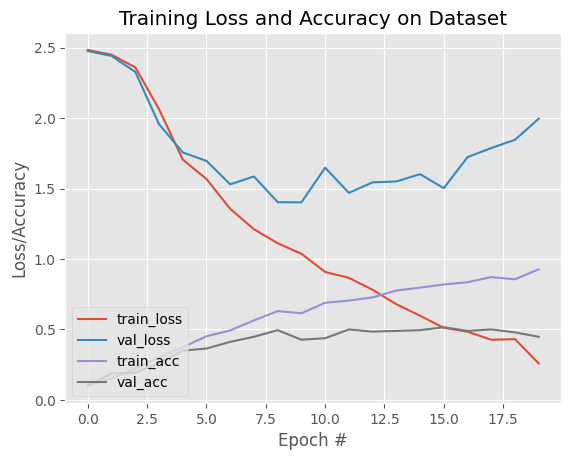

In [32]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

In [33]:

print("[INFO] evaluating network...")
with torch.no_grad():
    model.eval()
    targets = []
    predictions = []
    for (inputs,labels) in test_loader:
        inputs = inputs.to(device)        
        preds = model(inputs)
        
        predictions.extend(preds.argmax(axis=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())


[INFO] evaluating network...


In [34]:
assert len(predictions) == len(targets)


In [35]:

print(classification_report(np.array(targets), np.array(predictions), target_names=test_data.dataset.classes))

              precision    recall  f1-score   support

    bluebell       0.52      0.58      0.55        19
   buttercup       0.53      0.42      0.47        19
      crocus       0.33      0.06      0.10        17
    daffodil       0.29      0.64      0.40        14
       daisy       0.63      0.75      0.69        16
   dandelion       0.50      0.23      0.32        13
        iris       0.92      0.55      0.69        22
  lilyvalley       0.47      0.53      0.50        17
       pansy       0.50      0.62      0.55        13
    snowdrop       0.41      0.41      0.41        17
   sunflower       1.00      0.90      0.95        10
       tulip       0.22      0.33      0.26        15

    accuracy                           0.49       192
   macro avg       0.53      0.50      0.49       192
weighted avg       0.53      0.49      0.48       192

